# import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras , os , tqdm , cv2
from keras.models import Sequential
from keras.layers import Dense , Conv2D , MaxPooling2D , BatchNormalization , Dropout , Flatten
from keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

2025-09-05 08:20:14.262914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757060414.421836      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757060414.466619      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data

In [2]:
trainDir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
testDir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

In [3]:
def loadTrsinData (trainDir , imageWidth , imageHight) :
  classes = os.listdir(trainDir)
  imagesList = []
  labels = []
  for clas in tqdm.tqdm(classes) :
    classesPath = os.path.join(trainDir,clas)
    for image in os.listdir(classesPath) :
      imgPath = os.path.join(trainDir,clas,image)
      img = cv2.imread(imgPath)
      img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img , (imageWidth , imageHight))
      imagesList.append(img)
      labels.append(clas)

  return imagesList , labels

# Explore Data

In [4]:
def displaySampleOfData (trainDir , imageWidth , imageHight) :
  plt.figure(figsize=(10,15))
  classes = os.listdir(trainDir)
  for i,clas in tqdm.tqdm(enumerate(classes)):
    plt.subplot(6,5,i+1)
    classesPath = os.path.join(trainDir,clas)
    image = os.listdir(classesPath)[0]
    image = os.path.join(trainDir,clas,image)
    img = cv2.imread(image)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img , (imageWidth , imageHight))
    plt.title(clas)
    plt.imshow(img , cmap='gray')
  plt.show()


29it [00:01, 17.88it/s]


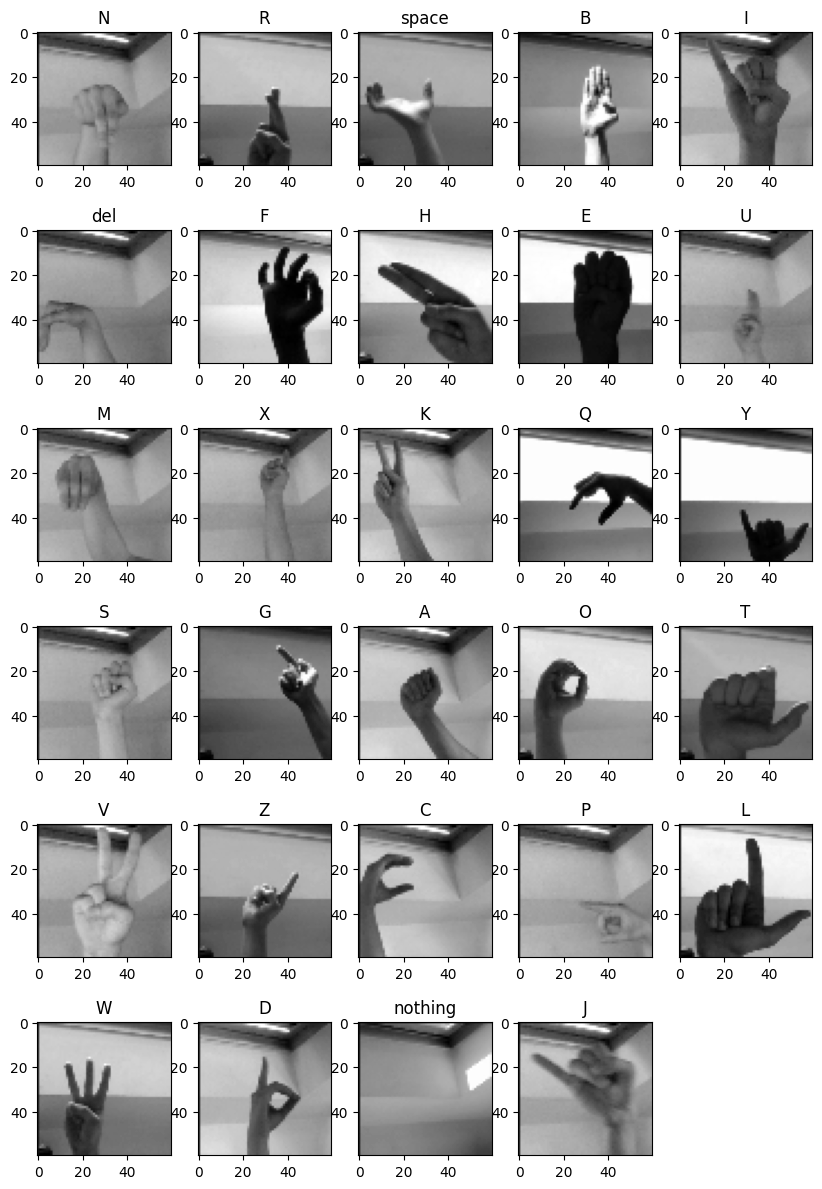

In [5]:
displaySampleOfData(trainDir ,60 ,60 )

In [6]:
# load data after explore the images and study it's case
X , y = loadTrsinData(trainDir , 60 , 60)

100%|██████████| 29/29 [07:51<00:00, 16.25s/it]


In [7]:
testImages = []
testLabels = []
for img in tqdm.tqdm(os.listdir(testDir)):
  trainImagePath = os.path.join(testDir , img)
  image = cv2.imread(trainImagePath)
  image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
  image = cv2.resize(image,(60,60))
  testImages.append(image)
  testLabels.append(img)

100%|██████████| 28/28 [00:00<00:00, 200.67it/s]


# Data preprocessing

## train

In [8]:
# shuffles x and y to make better training
XShuffled , yShuffled = shuffle(X,y,random_state=42)

In [9]:
# convert list to np array
xtrain = np.array(XShuffled)
ytrain = np.array(yShuffled)

In [10]:
# shape of xtrain
xtrain.shape

(87000, 60, 60)

In [11]:
# Scale the train data
xtrain = xtrain.astype('float32') / 255.0

In [12]:
# Reshape xtrain to fit conv network
xtrainReshaped = xtrain.reshape( (87000, 60, 60 , 1) )

In [13]:
xtrainReshaped.shape

(87000, 60, 60, 1)

In [14]:
# Create list of classes and dic to convert y labels to numbers
cats = [i for i in os.listdir(trainDir)]
categories = {}
for i,c in enumerate(cats) :
  categories[c] = i

In [15]:
# convert labels in ytrain to numbers
for i in range (len(ytrain)) :
  ytrain[i] = categories[ytrain[i]]

ytrain

array(['19', '9', '11', ..., '25', '0', '5'], dtype='<U7')

In [16]:
# Convert ytrain from numpy array to categoricl formate to fit in the training
ytrain = to_categorical(ytrain)

## test

In [17]:
testImages = np.array(testImages)
testLabels = np.array(testLabels)

In [18]:
testImages = testImages.astype('float32') / 255.0

In [19]:
testImages = testImages.reshape( (-1, 60, 60 , 1) )

In [20]:
for i in range(len(testLabels)) :
  testLabels[i] = testLabels[i].split('_')[0]

testLabels

array(['A', 'E', 'L', 'N', 'S', 'D', 'G', 'I', 'W', 'M', 'nothing', 'X',
       'H', 'Q', 'C', 'T', 'P', 'V', 'Y', 'U', 'space', 'O', 'B', 'R',
       'F', 'Z', 'J', 'K'], dtype='<U16')

In [21]:
testDic = {}
for i,c in enumerate(testLabels):
  testDic[c]=i

In [22]:
for i in range( len(testLabels) ):
  testLabels[i] = testDic[testLabels[i]]

In [23]:
testLabels

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27'], dtype='<U16')

In [24]:
testLabels = to_categorical(testLabels , num_classes=29)

In [25]:
testImages = np.array(testImages, dtype=np.float32)
testLabels = np.array(testLabels, dtype=np.int32)

# Data Modeling

In [26]:
Model = Sequential ([
    Conv2D(128 , (3,3) , activation='relu' , input_shape =(60,60,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64 , (3,3) , activation='relu' ),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(32 , (3,3) , activation='relu' ),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256 , activation='relu'),
    Dropout(0.2),
    Dense(128 , activation='relu'),
    Dropout(0.15),
    Dense(64 , activation='relu'),
    Dense(len(cats) , activation='softmax'),
])
Model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1757060902.421392      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 58, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 58, 58, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,525 (1.31 MB)

 Trainable params: 342,077 (1.30 MB)

 Non-trainable params: 448 (1.75 KB)

In [27]:
Model.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [28]:
# Add callbacks for better training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("best_custom_cnn.keras", save_best_only=True)
]

In [29]:
Model.fit(xtrainReshaped , ytrain  , validation_split=0.2 , epochs = 10, callbacks=callbacks)

Epoch 1/10


I0000 00:00:1757060910.720061      99 service.cc:148] XLA service 0x7d6148005d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757060910.720627      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757060911.195463      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  24/2175 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.0511 - loss: 3.5932 

I0000 00:00:1757060914.875034      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.4270 - loss: 1.8937 - val_accuracy: 0.8660 - val_loss: 0.3764
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8896 - loss: 0.3166 - val_accuracy: 0.8192 - val_loss: 0.5677
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9417 - loss: 0.1681 - val_accuracy: 0.8998 - val_loss: 0.3294
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9597 - loss: 0.1254 - val_accuracy: 0.9639 - val_loss: 0.1085
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9700 - loss: 0.0922 - val_accuracy: 0.9660 - val_loss: 0.1084
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9742 - loss: 0.0829 - val_accuracy: 0.9015 - val_loss: 0.4003
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9792 - loss: 0.0704 - val_accuracy: 0.9703 - val_loss: 0.1011
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9830 - loss: 0.0575 - val

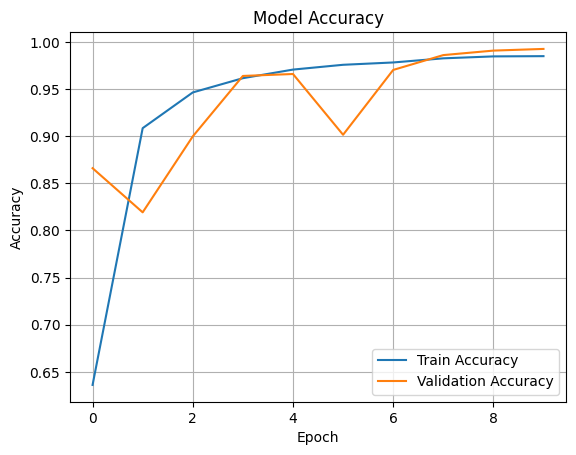

In [30]:
plt.plot(Model.history.history['accuracy'], label='Train Accuracy')
plt.plot(Model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Save the custom CNN model
Model.save('custom_cnn_asl_model.keras')
print("Custom CNN model saved as 'custom_cnn_asl_model.keras'")

# Also save in .h5 format for compatibility
Model.save('custom_cnn_asl_model.h5')
print("Custom CNN model also saved as 'custom_cnn_asl_model.h5'")

# Save the label mapping for the custom model
import json
label_mapping = {v: k for k, v in categories.items()}  # reverse mapping (index -> class name)
with open('custom_cnn_labels.json', 'w') as f:
    json.dump(label_mapping, f)
print("Label mapping saved as 'custom_cnn_labels.json'")

Custom CNN model saved as 'custom_cnn_asl_model.keras'
Custom CNN model also saved as 'custom_cnn_asl_model.h5'
Label mapping saved as 'custom_cnn_labels.json'


VGG-16

In [32]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TF version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [33]:
trainDir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
testDir  = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

# Vérifie le dossier
assert os.path.isdir(trainDir), f"trainDir introuvable: {trainDir}"

# Récupère et trie les classes (un dossier = une classe)
classes = sorted([d for d in os.listdir(trainDir) if os.path.isdir(os.path.join(trainDir, d))])
num_classes = len(classes)
print("Nombre de classes détectées :", num_classes)
print(classes)


Nombre de classes détectées : 29
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [34]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32   # si OOM, baisser à 16 ou 8
SEED = 42

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    trainDir,
    target_size=IMG_SIZE,
    color_mode='rgb',            # important : RGB pour VGG16
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_directory(
    trainDir,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

print("Mapping classes -> indices :", train_gen.class_indices)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Mapping classes -> indices : {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [35]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Geler toutes les couches pour commencer (feature extractor)
for layer in base_model.layers:
    layer.trainable = False

print("Nombre de couches VGG16 :", len(base_model.layers))
base_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Nombre de couches VGG16 : 19


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [42]:
# Use Functional API instead of Sequential to avoid layer connection issues
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Create input layer explicitly
inputs = Input(shape=(224, 224, 3))

# Connect base model
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', name='dense_1')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', name='dense_2')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

# Create model using Functional API
model = Model(inputs=inputs, outputs=outputs, name='vgg16_transfer_asl')

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "vgg16_transfer_asl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,882,653 (56.77 MB)

 Trainable params: 167,965 (656.11 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [45]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1),
    ModelCheckpoint("vgg16_transfer_asl_best.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [46]:
EPOCHS = 10   # ou 8-12 selon le temps

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9709 - loss: 0.0988
Epoch 1: val_accuracy improved from -inf to 0.85408, saving model to vgg16_transfer_asl_best.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 198s 91ms/step - accuracy: 0.9709 - loss: 0.0988 - val_accuracy: 0.8541 - val_loss: 0.5126 - learning_rate: 1.0000e-04
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9801 - loss: 0.0672
Epoch 2: val_accuracy improved from 0.85408 to 0.86287, saving model to vgg16_transfer_asl_best.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 198s 91ms/step - accuracy: 0.9801 - loss: 0.0672 - val_accuracy: 0.8629 - val_loss: 0.4667 - learning_rate: 1.0000e-04
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9868 - loss: 0.0447
Epoch 3: val_accuracy improved from 0.86287 to 0.87155, saving model to vgg16_transfer_asl_best.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 199s 91ms/step - accuracy: 0.9868 - loss: 0.0447 - val_accuracy: 0.8716 - val_loss: 0.4490 - learni

In [48]:
# Save the final VGG16 transfer learning model
model.save('vgg16_transfer_asl_final.keras')
print("VGG16 transfer learning model saved as 'vgg16_transfer_asl_final.keras'")

# Also save in .h5 format for compatibility
model.save('vgg16_transfer_asl_final.h5')
print("VGG16 transfer learning model also saved as 'vgg16_transfer_asl_final.h5'")

# Save the label mapping for VGG16 model (from ImageDataGenerator)
import json
vgg16_label_mapping = {v: k for k, v in train_gen.class_indices.items()}  # reverse mapping (index -> class name)
with open('vgg16_transfer_labels.json', 'w') as f:
    json.dump(vgg16_label_mapping, f)
print("VGG16 label mapping saved as 'vgg16_transfer_labels.json'")

# Print training history summary
print(f"\nTraining completed!")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

VGG16 transfer learning model saved as 'vgg16_transfer_asl_final.keras'
VGG16 transfer learning model also saved as 'vgg16_transfer_asl_final.h5'
VGG16 label mapping saved as 'vgg16_transfer_labels.json'

Training completed!
Best validation accuracy: 0.8755
Final training accuracy: 0.9971
Final validation accuracy: 0.8755


In [49]:
# Model Summary and Saved Files
print("="*60)
print("MODEL TRAINING COMPLETED - SUMMARY")
print("="*60)
print("\n SAVED MODEL FILES:")
print("1. Custom CNN Model:")
print("   - custom_cnn_asl_model.keras")
print("   - custom_cnn_asl_model.h5")
print("   - custom_cnn_labels.json")
print("\n2. VGG16 Transfer Learning Model:")
print("   - vgg16_transfer_asl_final.keras (final model)")
print("   - vgg16_transfer_asl_final.h5 (final model)")
print("   - vgg16_transfer_asl_best.keras (best checkpoint)")
print("   - vgg16_transfer_labels.json")
print("\n MODEL SPECIFICATIONS:")
print("1. Custom CNN:")
print("   - Input: 60x60 grayscale images")
print("   - Architecture: Custom 3-layer CNN")
print("   - Classes: 29 ASL alphabet signs")
print("\n2. VGG16 Transfer Learning:")
print("   - Input: 224x224 RGB images")
print("   - Architecture: VGG16 + custom classification head")
print("   - Classes: 29 ASL alphabet signs")
print("\n USAGE RECOMMENDATION:")
print("- Use VGG16 model for better accuracy (transfer learning)")
print("- Use Custom CNN for faster inference (smaller model)")
print("- Both models ready for frontend integration!")
print("="*60)

MODEL TRAINING COMPLETED - SUMMARY

 SAVED MODEL FILES:
1. Custom CNN Model:
   - custom_cnn_asl_model.keras
   - custom_cnn_asl_model.h5
   - custom_cnn_labels.json

2. VGG16 Transfer Learning Model:
   - vgg16_transfer_asl_final.keras (final model)
   - vgg16_transfer_asl_final.h5 (final model)
   - vgg16_transfer_asl_best.keras (best checkpoint)
   - vgg16_transfer_labels.json

 MODEL SPECIFICATIONS:
1. Custom CNN:
   - Input: 60x60 grayscale images
   - Architecture: Custom 3-layer CNN
   - Classes: 29 ASL alphabet signs

2. VGG16 Transfer Learning:
   - Input: 224x224 RGB images
   - Architecture: VGG16 + custom classification head
   - Classes: 29 ASL alphabet signs

 USAGE RECOMMENDATION:
- Use VGG16 model for better accuracy (transfer learning)
- Use Custom CNN for faster inference (smaller model)
- Both models ready for frontend integration!
